In [1]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (TwoSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip

/home/soyeon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [3]:
import pandas as pd
sub_info = pd.read_table('/home/soyeon/socialcomparison/participants.tsv')
sub_info

,participant_id,gender,group
0,sub-01,female,overweight
1,sub-02,female,overweight
2,sub-03,female,normalweight
3,sub-04,female,overweight
4,sub-05,female,normalweight
5,sub-06,female,normalweight
6,sub-07,female,normalweight
7,sub-08,female,normalweight
8,sub-09,female,overweight
9,sub-10,female,overweight


In [4]:
normal = sub_info[sub_info.group == 'normalweight']
over = sub_info[sub_info.group == 'overweight']
over

,participant_id,gender,group
0,sub-01,female,overweight
1,sub-02,female,overweight
3,sub-04,female,overweight
8,sub-09,female,overweight
9,sub-10,female,overweight
10,sub-11,female,overweight
14,sub-15,female,overweight
17,sub-20,female,overweight
18,sub-21,female,overweight
19,sub-22,female,overweight


In [5]:
import numpy as np
normalweight = normal['participant_id']
overweight = over['participant_id'].tolist()
overweight

['sub-01',
 'sub-02',
 'sub-04',
 'sub-09',
 'sub-10',
 'sub-11',
 'sub-15',
 'sub-20',
 'sub-21',
 'sub-22',
 'sub-23',
 'sub-24',
 'sub-25']

In [6]:
experiment_dir = '/home/soyeon/output'
output_dir = 'datasink'
working_dir = 'workingdir'

mask = "/home/soyeon/data/fmri_study/pad/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz"

In [13]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# TwoSampleTTestDesign - creates two sample T-Test Design
twosamplettestdes = Node(TwoSampleTTestDesign(),
                         name="twosampttestdes")
twosamplettestdes.inputs.group1_files = ['/home/soyeon/output/datasink/norm_ants/%s_fwhm6/con_0007_trans.nii' % (normal)
                                         for normal in normalweight]
twosamplettestdes.inputs.group2_files = ['/home/soyeon/output/datasink/norm_ants/%s_fwhm6/con_0007_trans.nii' % (over)
                                         for over in overweight]

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['normalweight', 'T', ['Group_{1}'], [1]]
cont2 = ['overweight', 'T', ['Group_{2}'], [1]]
cont3 = ['normalweight > overweight', 'T', ['Group_{1}','Group_{2}'], [1, -1]]
cont4 = ['overweight > normalweight', 'T', ['Group_{1}','Group_{2}'], [-1, 1]]
level2conestimate.inputs.contrasts = [cont1, cont2, cont3, cont4]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [14]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(gunzip, twosamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (twosamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2estimate, datasink, [('mask_image',
                                                 '2ndLevel.@mask')]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    ])

181101-13:38:53,525 nipype.workflow INFO:
	 Generated workflow graph: /home/soyeon/output/workingdir/l2analysis/graph.png (graph2use=colored, simple_form=True).


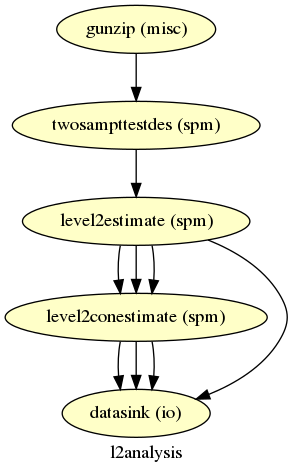

In [15]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'l2analysis', 'graph.png'))

In [38]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

181101-14:07:36,508 nipype.workflow INFO:
	 Workflow l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
181101-14:07:36,522 nipype.workflow INFO:
	 Running in parallel.
181101-14:07:36,527 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 4/4.
181101-14:07:36,609 nipype.workflow INFO:
	 [Job 0] Cached (l2analysis.gunzip).
181101-14:07:38,597 nipype.workflow INFO:
	 [Job 1] Cached (l2analysis.twosampttestdes).
181101-14:07:40,597 nipype.workflow INFO:
	 [Job 2] Cached (l2analysis.level2estimate).
181101-14:07:42,600 nipype.workflow INFO:
	 [Job 3] Cached (l2analysis.level2conestimate).
181101-14:07:44,652 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.datasink" in "/home/soyeon/output/workingdir/l2analysis/datasink".
181101-14:07:44,686 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
181101-14:07:45,560 nipype.workflow INFO:
	 [Node] Finished "l2analysis.da

In [39]:
from nilearn.plotting import (plot_stat_map, plot_img)
%matplotlib inline
anatimg = '/home/soyeon/data/fmri_study/pad/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

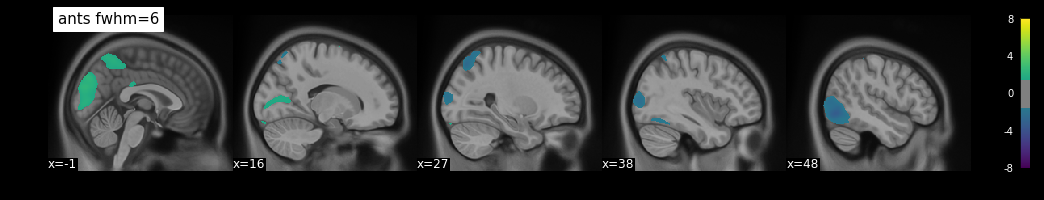

In [52]:
plot_stat_map(
    '/home/soyeon/output/datasink/2ndLevel/con_0001.nii', title='ants fwhm=6', dim=1,
    bg_img=anatimg, threshold=1.5, vmax=8, display_mode='x', cut_coords=(48, 38, 27, 16, -1), cmap='viridis', draw_cross=True);

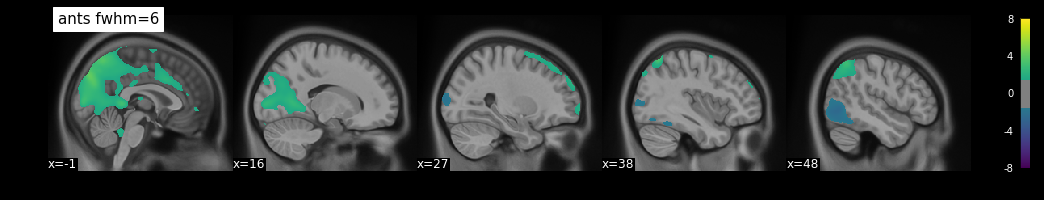

In [51]:
plot_stat_map(
    '/home/soyeon/output/datasink/2ndLevel/con_0002.nii', title='ants fwhm=6', dim=1,
    bg_img=anatimg, threshold=1.5, vmax=8, display_mode='x', cut_coords=(48, 38, 27, 16, -1), cmap='viridis', draw_cross=True);

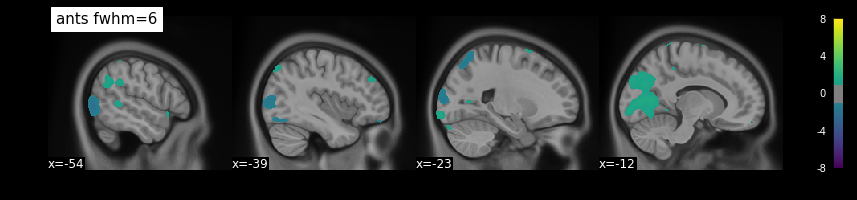

In [55]:
plot_stat_map(
    '/home/soyeon/output/datasink/2ndLevel/con_0001.nii', title='ants fwhm=6', dim=1,
    bg_img=anatimg, threshold=1, vmax=8, display_mode='x', cut_coords=(-12, -23, -39, -54), cmap='viridis', draw_cross=True);

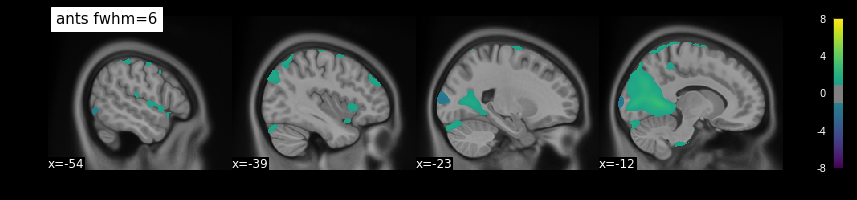

In [56]:
plot_stat_map(
    '/home/soyeon/output/datasink/2ndLevel/con_0002.nii', title='ants fwhm=6', dim=1,
    bg_img=anatimg, threshold=1, vmax=8, display_mode='x', cut_coords=(-12, -23, -39, -54), cmap='viridis', draw_cross=True);

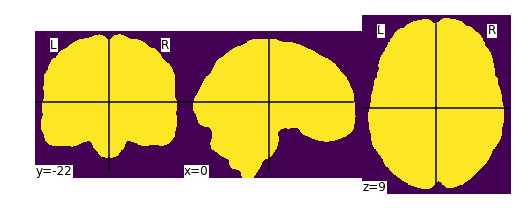

In [42]:
plot_img('/home/soyeon/output/datasink/2ndLevel/mask.nii')